In [1]:
import flwr as fl
import tensorflow as tf
from tensorflow import keras
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def getDist(y):
    ax = sns.countplot(y)
    ax.set(title="Count of data classes")
    plt.show()

def getData(dist, x, y):
    dx = []
    dy = []
    counts = [0 for i in range(10)]
    for i in range(len(x)):
        if counts[y[i]]<dist[y[i]]:
            dx.append(x[i])
            dy.append(y[i])
            counts[y[i]] += 1
        
    return np.array(dx), np.array(dy)

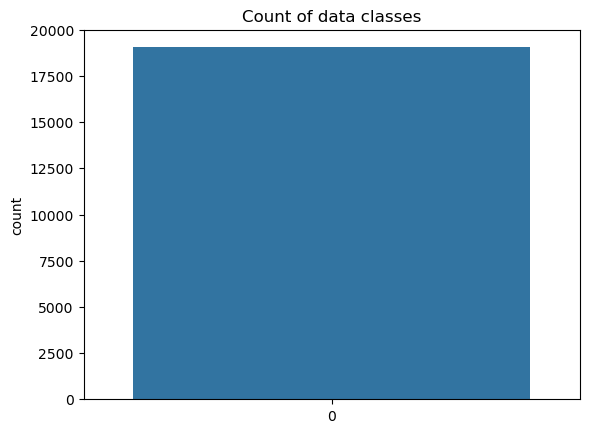

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
dist = [4000, 4000, 4000, 3000, 10, 10, 10, 10, 4000, 10]
x_train, y_train = getData(dist, x_train, y_train)
getDist(y_train)

In [3]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

2024-02-21 01:32:44.203323: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-21 01:32:44.203344: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-21 01:32:44.203351: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-21 01:32:44.203377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-21 01:32:44.203396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def get_parameters(self,config):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        r = model.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test), verbose=0)
        hist = r.history
        print("Fit history : " ,hist)
        return model.get_weights(), len(x_train), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        print("Eval accuracy : ", accuracy)
        return loss, len(x_test), {"accuracy": accuracy}

fl.client.start_numpy_client(
        server_address="localhost:8000", 
        client=FlowerClient(), 
        grpc_max_message_length = 1024*1024*1024
)

WARNING flwr 2024-02-21 01:32:44,749 | logger.py:118 | 
        DEPRECATED FEATURE: flwr.client.start_numpy_client() is deprecated. 
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), # <-- where FlowerClient is of type flwr.client.NumPyClient object
	)
	Using `start_numpy_client()` is deprecated.

        This is a deprecated feature. It will be removed
        entirely in future versions of Flower.
        
INFO flwr 2024-02-21 01:32:44,761 | grpc.py:52 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flwr 2024-02-21 01:32:44,762 | connection.py:55 | ChannelConnectivity.IDLE
DEBUG flwr 2024-02-21 01:32:44,764 | connection.py:55 | ChannelConnectivity.CONNECTING
DEBUG flwr 2024-02-21 01:32:44,765 | connection.py:55 | ChannelConnectivity.READY
